In [1]:
import scvelo as scv
import scanpy as sc

In [2]:
import numpy as np
import pandas as pd
def extract_paga_transitions(adata, key):
    clusters = adata.obs[key].cat.categories
    paga = np.array(adata.uns['paga']['transitions_confidence'].todense())
    paga_con = np.array(adata.uns['paga']['connectivities'].todense())
    transitions = []
    connectivities = []
    confidence = []
    for i in range(clusters.shape[0]):
        for j in range(clusters.shape[0]):
            if paga[i,j] > 0:
                transition = clusters[j] + '->' + clusters[i]
                transitions.append(transition)
                confidence.append(paga[i,j])
                connectivities.append(paga_con[i,j])
                
    return pd.DataFrame({'transition': transitions, 'confidence': confidence,
                        'connectivity': connectivities})

In [3]:
adata = sc.read('../latentvelo/fits/latentvelo_endothelial_Sept11.h5ad')

In [4]:
import pandas as pd
meta = pd.read_csv('../../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c3_final_metadata.csv',
                  index_col=0)

adata.obs['id'] = [str(x.split('-')[0]) +'-'+ str(x.split('-')[1]) for x in adata.obs.index.values]
adata.obs = adata.obs.set_index('id')
adata.obs['cell_type_num'] = meta['cell_type_Aug'].astype('category')

endo_palette = {'Aerocyte (6)':'#1f77b4', 'Arterial EC (8)':'#ff7f0e', 
                'KIT+CA4+ endothelial cells (2)':'#2ca02c', 'Cycling early capillaries (10)':'#d62728', 
                'Erythrocyte-like EC-1 (1)':'#9467bd', 'Erythrocyte-like EC-2 (3)':'#8c564b', 
                'Intermediate lymphatic EC (4)':'#7f7f7f', 'Lymphatic EC (9)':'#e377c2', 
                'Venous EC (5)':'#bcbd22', 'gCap (7)':'#17becf'}

adata.obs['cell_type_num'] = adata.obs['cell_type_num'].cat.rename_categories({'Intermediate lymphatic EC (4)':'Lymphatic EC (9)',
                                                                              'Lymphatic EC (9)':'Intermediate lymphatic EC (4)'})


In [5]:
scv.pp.neighbors(adata, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(adata, vkey='spliced_velocity')

computing neighbors
    finished (0:01:46) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/13376 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/latentvelo_endothelial_velocity.png


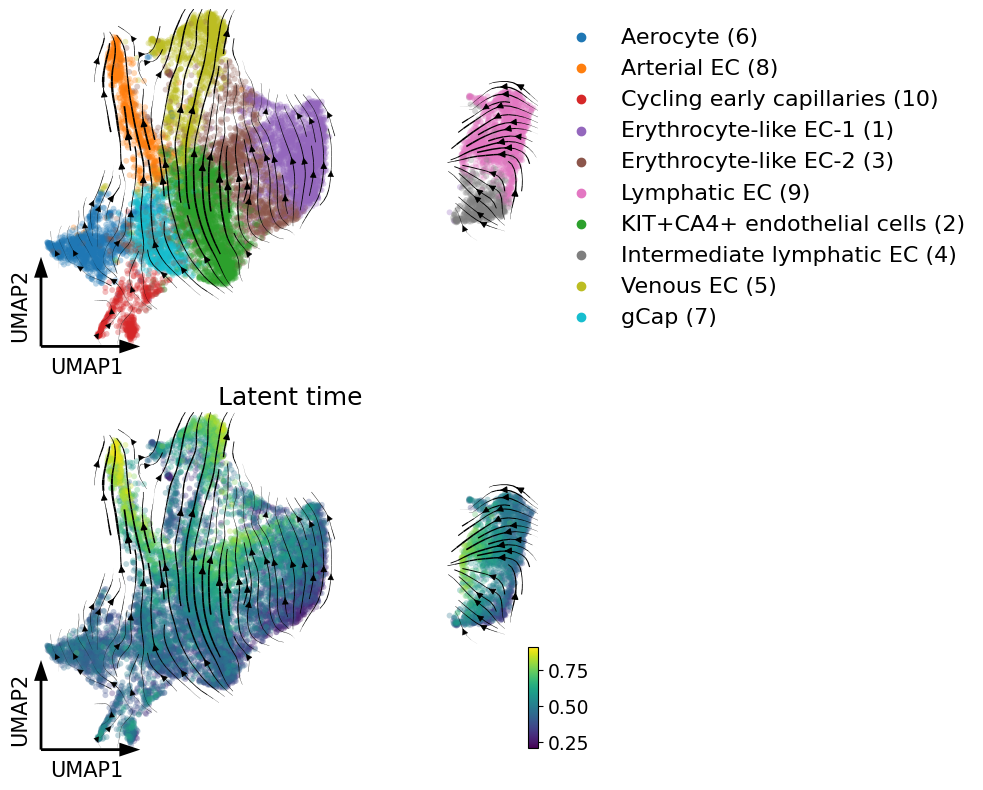

In [6]:
scv.pl.velocity_embedding_stream(adata, vkey='spliced_velocity', 
                                 color=['cell_type_num', 'latent_time'], frameon='artist', fontsize=18,
                                cutoff_perc=0, legend_loc='right', legend_fontsize=16,
                                 title=['', 'Latent time'],
                                 palette=endo_palette,
                                 ncols=1, save='figures/latentvelo_endothelial_velocity.png')

In [7]:
scv.tl.paga(adata, vkey='spliced_velocity', 
            use_time_prior='latent_time', groups='cell_type_num',
           minimum_spanning_tree=False)

running PAGA using priors: ['latent_time']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [8]:
extract_paga_transitions(adata, 'cell_type_num')

,transition,confidence,connectivity
0,Cycling early capillaries (10)->Aerocyte (6),0.055396,0.926360
1,Aerocyte (6)->Arterial EC (8),0.048852,0.224222
2,Erythrocyte-like EC-1 (1)->Arterial EC (8),0.056094,0.233323
3,Erythrocyte-like EC-2 (3)->Arterial EC (8),0.092890,0.498420
4,KIT+CA4+ endothelial cells (2)->Arterial EC (8),0.097218,0.371691
5,Venous EC (5)->Arterial EC (8),0.041494,0.245937
6,gCap (7)->Arterial EC (8),0.060289,0.330694
7,Erythrocyte-like EC-2 (3)->Erythrocyte-like EC...,0.084900,1.000000
8,Intermediate lymphatic EC (4)->Erythrocyte-lik...,0.074223,0.635722
9,Aerocyte (6)->Erythrocyte-like EC-2 (3),0.029043,0.536914


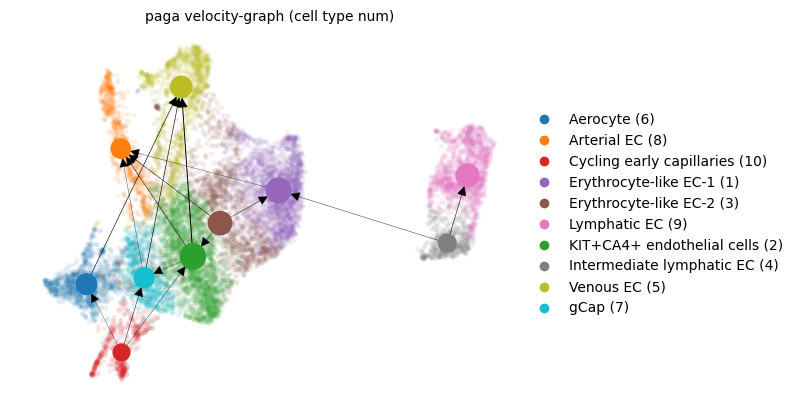

In [9]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            edge_width_scale=0.5, dashed_edges=None,
            transiitons='transitions_confidence',solid_edges='transitions_confidence',
            min_edge_width=0, node_size_scale=1.5, threshold=0.052)

saving figure to file figures/latentvelo_endothelial_PAGA.pdf


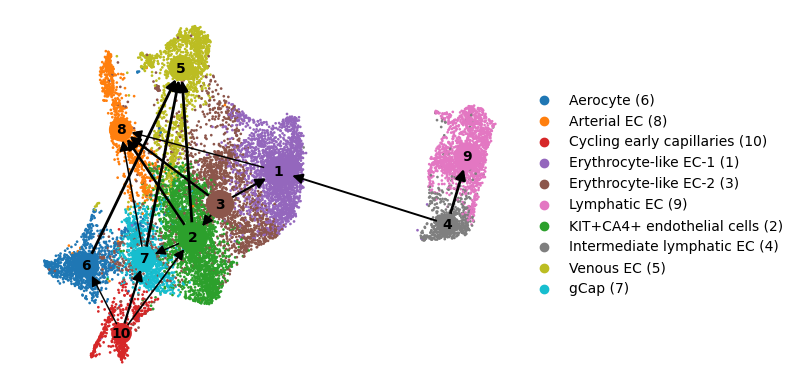

In [10]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
scv.pl.paga(adata, size=50, alpha=.25, basis='umap',
            edge_width_scale=2.5,
            min_edge_width=0, node_size_scale=2., threshold=0.05,
           dashed_edges = None, ax=ax, show=False)


for ct in adata.obs.cell_type_num.unique():
    X_emb = np.array(adata[adata.obs['cell_type_num']==ct].obsm['X_umap'])
    x_pos, y_pos = np.median(X_emb, axis=0)
    label = ct[-4:].split('(')[1].split(')')[0]
    if False:
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', verticalalignment='center',
               color='white',fontweight='bold')
    else:
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', 
                verticalalignment='center',fontweight='bold')

scv.pl.umap(adata, color='cell_type_num', ax=ax, legend_loc='right',title='',size=15,
            save='figures/latentvelo_endothelial_PAGA.pdf', rasterized=True)

plt.show()

In [11]:
pos = adata.uns['paga']['pos']

In [12]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()

for i,ct in enumerate(adata.obs.cell_type_num.cat.categories):
    X_emb = np.array(adata[adata.obs['cell_type_num']==ct].obsm['X_umap'])
    x_pos, y_pos = pos[i]
    label = ct[-4:].split('(')[1].split(')')[0]
    ax.scatter(x_pos, y_pos, zorder=1000, color = endo_palette[ct], s=200)
    ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', 
                verticalalignment='center',fontweight='bold',fontsize=12)
        
scv.pl.velocity_embedding_stream(adata, vkey='spliced_velocity', cutoff_perc=0, show=False,
                                 color='cell_type_num', ax=ax, legend_loc='right', palette=endo_palette,

scv.pl.paga(adata, size=100, alpha=.25, pos=pos, arrowsize=0,#
            edge_scale_width=0,solid_edges=None,max_edge_width=0,title='',
            min_edge_width=0, node_size_scale=1, threshold=0.045,
           dashed_edges = None, ax=ax, show=False,palette =endo_palette, zorder=1000000000,
           save='figures/latentvelo_Endothelial_velocity.svg', dpi=60)

plt.show()

saving figure to file figures/latentvelo_Endothelial_velocity.svg


In [13]:
pd.DataFrame(adata.uns['paga']['transitions_confidence'].todense(),index=adata.obs.cell_type_num.cat.categories, 
             columns=adata.obs.cell_type_num.cat.categories).to_csv('data/Endothelial_PAGA.csv')